# CUSUM Filter
Cumulative sum https://en.wikipedia.org/wiki/CUSUM

Helpful project: https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/Labeling%20and%20MetaLabeling%20for%20Supervised%20Classification.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
df = pd.read_csv("../data/testing.csv")
df["time"] = list(map(lambda x: datetime.datetime.fromtimestamp(x/1000), df.time))
df = df.set_index(["time"], drop=True)
df = df[~df.index.duplicated(keep='first')]
len(df)

79373

In [3]:
def get_daily_vol(close, span0=100):
    """
    daily vol, reindexed to close
    
    Arguments:
    close -- daily close (probably Pandas series)
    span0 -- span lol (probably int)
    Purpose:
    use the output of this function to set default profit taking and stop-loss limit
    """
    df0 = close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0=df0[df0>0]
    df0=pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
    df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily returns
    df0=df0.ewm(span=span0).std()
    return df0

In [4]:
vol = get_daily_vol(df.close)

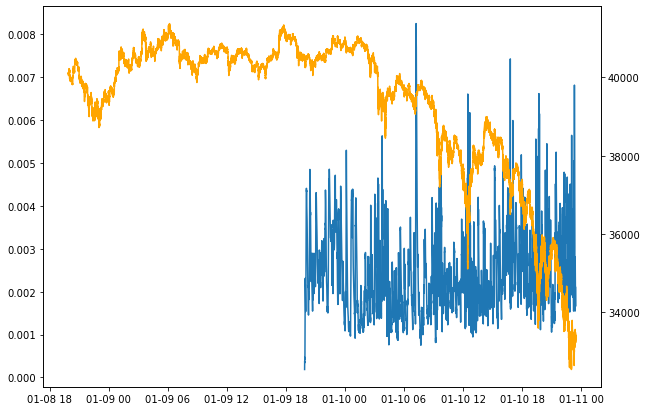

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(vol)

ax1 = ax.twinx()
ax1.plot(df.close, color='orange')

In [6]:
def get_t_events(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(gRaw).diff().dropna()
    for i in diff.index[1:]:
        try:
            pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        except Exception as e:
            print(e)
            print(sPos+diff.loc[i], type(sPos+diff.loc[i]))
            print(sNeg+diff.loc[i], type(sNeg+diff.loc[i]))
            break
        sPos, sNeg=max(0., pos), min(0., neg)
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

In [7]:
t_events = get_t_events(df.close,h=vol.mean())
t_events

DatetimeIndex(['2021-01-08 19:57:56.847000', '2021-01-08 20:01:42.971000',
               '2021-01-08 20:02:14.242000', '2021-01-08 20:02:40.178000',
               '2021-01-08 20:04:59.035000', '2021-01-08 20:13:07.605000',
               '2021-01-08 20:18:48.288000', '2021-01-08 20:21:14.739000',
               '2021-01-08 20:22:50.773000', '2021-01-08 20:23:21.807000',
               ...
               '2021-01-10 23:23:15.016000', '2021-01-10 23:23:42.399000',
               '2021-01-10 23:23:55.817000', '2021-01-10 23:24:03.733000',
               '2021-01-10 23:24:24.929000', '2021-01-10 23:24:28.092000',
               '2021-01-10 23:25:02.191000', '2021-01-10 23:25:37.310000',
               '2021-01-10 23:25:54.102000', '2021-01-10 23:26:00.159000'],
              dtype='datetime64[ns]', length=3528, freq=None)

In [8]:
d = {"time":t_events, "event":np.ones(3528)}

In [9]:
d = pd.DataFrame(d)

In [10]:
test = []
for row in range(len(d)):
    test.append(df.loc[d.iloc[row].time].close)

In [11]:
df.loc[d.iloc[1].time].close

40120.0

In [12]:
d["event"] = test

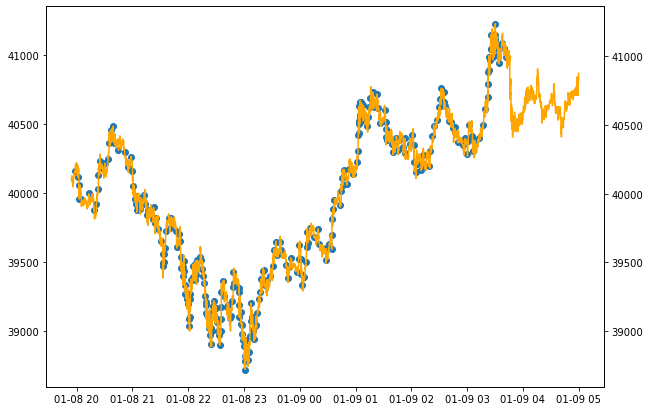

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(d.time[:300], d.event[:300])

ax1 = ax.twinx()
ax1.plot(df.close[:10000], color='orange')

## Add vertical barriers

In [14]:
def addVerticalBarrier(tEvents, close, numDays=1):
    t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1

In [15]:
t1 = addVerticalBarrier(t_events, df.close, numDays=1)
t1

2021-01-08 19:57:56.847   2021-01-09 19:58:02.136
2021-01-08 20:01:42.971   2021-01-09 20:01:46.999
2021-01-08 20:02:14.242   2021-01-09 20:02:18.078
2021-01-08 20:02:40.178   2021-01-09 20:02:50.652
2021-01-08 20:04:59.035   2021-01-09 20:05:07.081
                                    ...          
2021-01-09 23:00:05.626   2021-01-10 23:00:06.758
2021-01-09 23:13:07.833   2021-01-10 23:13:08.116
2021-01-09 23:14:01.039   2021-01-10 23:14:02.174
2021-01-09 23:14:13.910   2021-01-10 23:14:15.963
2021-01-09 23:17:58.636   2021-01-10 23:17:58.851
Name: time, Length: 739, dtype: datetime64[ns]

## Apply triple barrier

In [16]:
def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)
    
    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

def apply_triple_barrier(close, events, pt_sl, molecule):
    """
    apply stop loss /profit taking, if it takes place between t1 (end of event)
    
    Arguments:
    close -- pandas series of prices
    events -- pandas dataframe with columns:
        t1: The timestamp of vertical barrier. When the value is np.nan, there will not be a vertical barrier
        trgt: The unit width of the horizontal barriers
    pt_sl -- a list of two non-negative float values:
        pt_sl[0] -- the factor that multiplies trgt to set the width of the upper barrier. If 0, there will not be an upper barrier
        pt_sl[1] -- the factor that multiples trgt to set the width of the lower barrier. If 0, there will not be a lower barrier
    molecule -- A list with the subset of event indices that will be processed by a single thread
    
    Output:
    The output from this function is a pandas dataframe containing the timestamps (if any) at which each barrier was touched.
    """
    events0 = events.loc[molecule]
    out = events0[['t1']].copy(deep=True)
    if pt_sl[0]>0:
        pt=pt_sl[0]*events0['trgt']
    else:
        pt=pd.Series(index=events.index) #NaNs
    if pt_sl[1]>0:
        sl=-pt_sl[1]*events0['trgt']
    else:
        sl=pd.Series(index=events.index) #NaNs
    for loc, t1 in events0['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] #path prices
        df0=(df0/close[loc]-1)*events0.at[loc, 'side'] #path returns
        out.loc[loc, 'sl']=df0[df0<sl[loc]].index.min() #earliest stop loss
        out.loc[loc, 'pt']=df0[df0>pt[loc]].index.min() #earliest profit taking
    return out

In [17]:
def get_events(close, t_events, pt_sl, trgt, min_ret, num_threads, t1=False):
    """
    finds the time of the first barrier touch
    
    Arguments:
    close -- a pandas series of prices
    t_events -- the pandas timeindex containing the timestamps that will seed every triple barrier. These are the timestamps discussed in section 2.5
    pt_sl -- a non-negative float that sets the width of the two barriers. A 0 value means that the respective horizontal barrier (profit taking and/or stop loss) will be disabled
    t1 -- a pandas series with the timestamps of the vertical barriers. We pass a False when we watn to disable vertical barriers
    trgt -- a pandas series of targets, expressed in terms of absolute returns
    min_ret -- the minimum target return required for running a triple barrier search
    num_threads -- the number of threads concurrently used by the function
    
    Output:
    pandas dataframe with columns
    t1 -- the timestamp at which the first barrier is touched
    trgt -- the target that was used to generate the horizontal barriers
    """
    #Get target
#     trgt = trgt.loc[t_events]
    trgt = trgt.reindex(t_events)

    trgt = trgt[trgt>min_ret] #min_ret
    
    #Get t1 (max holding period)
    if t1 is False:
        t1=pd.Series(pd.NaT, index=t_events)
    # form events object, apply stop loss on t1
    side0 = pd.Series(1., index=trgt.index)
    print(side0)
    events=pd.concat({'t1':t1, 'trgt':trgt, 'side':side0},
                    axis=1).dropna(subset=['trgt'])
#     df0=mpPandasObj(func=apply_triple_barrier, pdObj=('molecule', events.index),
#                    numThreads=num_threads, close=close, events=events, ptSL=[pt_sl, pt_sl])
    df0 = apply_triple_barrier(close, events, pt_sl, events.index)
    events['t1']=df0.dropna(how='all').min(axis=1) #pd.min ignores nan
    events=events.drop('side', axis=1)
    return events

In [41]:
trgt

2021-01-08 19:57:56.847   NaN
2021-01-08 20:01:42.971   NaN
2021-01-08 20:02:14.242   NaN
2021-01-08 20:02:40.178   NaN
2021-01-08 20:04:59.035   NaN
                           ..
2021-01-10 23:24:28.092   NaN
2021-01-10 23:25:02.191   NaN
2021-01-10 23:25:37.310   NaN
2021-01-10 23:25:54.102   NaN
2021-01-10 23:26:00.159   NaN
Name: close, Length: 3528, dtype: float64

In [18]:
# create target series
ptsl = [1,1]
target=vol
# select minRet
minRet = 0.0001

# Run in single-threaded mode on Windows
    
events = get_events(df.close,t_events,ptsl,target,minRet,1,t1=t1)


2021-01-09 19:56:34.575    1.0
2021-01-09 19:58:15.444    1.0
2021-01-09 19:58:30.182    1.0
2021-01-09 20:01:02.852    1.0
2021-01-09 20:03:06.049    1.0
                          ... 
2021-01-10 23:24:28.092    1.0
2021-01-10 23:25:02.191    1.0
2021-01-10 23:25:37.310    1.0
2021-01-10 23:25:54.102    1.0
2021-01-10 23:26:00.159    1.0
Length: 2849, dtype: float64


In [19]:
events

,t1,trgt
2021-01-09 19:56:34.575,2021-01-09 19:56:57.036,0.000510
2021-01-09 19:58:15.444,2021-01-09 19:58:30.182,0.001966
2021-01-09 19:58:30.182,2021-01-09 20:00:25.179,0.002218
2021-01-09 20:01:02.852,2021-01-09 20:02:02.665,0.001612
2021-01-09 20:03:06.049,2021-01-09 20:14:42.323,0.002897
...,...,...
2021-01-10 23:24:28.092,2021-01-10 23:25:02.191,0.002268
2021-01-10 23:25:02.191,2021-01-10 23:25:52.641,0.002139
2021-01-10 23:25:37.310,2021-01-10 23:25:54.247,0.001870
2021-01-10 23:25:54.102,2021-01-10 23:25:55.044,0.001681


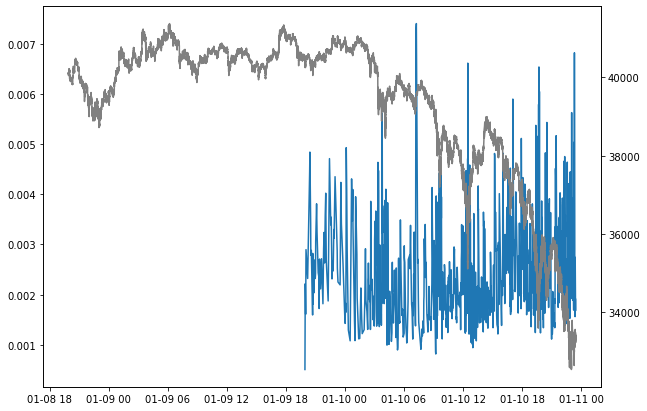

In [20]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(events.index, events.trgt)

ax1 = ax.twinx()
ax1.plot(df.close, color="gray")

## Apply getBins to generate the labels.

In [21]:
def get_bins(events, close):
    """
    Output:
    dataframe with columns:
    ret -- the return realized at the time of the first touched barrier
    bin -- the label, {-1, 0, 1}, as a function of the sign of the outcome. The funciton can be easily adjusted to label as 0 those events when the vertical barrier was touched first"""
    # prices aligned with events
    events0 = events.dropna(subset=['t1'])
    px=events0.index.union(events0['t1'].values).drop_duplicates()
    px=close.reindex(px, method='bfill')
    # Create out object
    out=pd.DataFrame(index=events0.index)
    out['ret']=px.loc[events0['t1'].values].values/px.loc[events0.index]-1
    out['bin']=np.sign(out['ret'])
    return out

In [22]:
labels = get_bins(events, df.close)
labels

,ret,bin
2021-01-09 19:56:34.575,-0.000682,-1.0
2021-01-09 19:58:15.444,0.002166,1.0
2021-01-09 19:58:30.182,-0.002492,-1.0
2021-01-09 20:01:02.852,0.001797,1.0
2021-01-09 20:03:06.049,0.003038,1.0
...,...,...
2021-01-10 23:24:24.929,-0.003388,-1.0
2021-01-10 23:24:28.092,0.002720,1.0
2021-01-10 23:25:02.191,-0.002214,-1.0
2021-01-10 23:25:37.310,-0.003005,-1.0


# 2. Use snippet 3.8 to drop under-populated labels

In [23]:
def drop_labels(events, minPct=.05):
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

In [24]:
clean_labels = drop_labels(labels)
clean_labels

,ret,bin
2021-01-09 19:56:34.575,-0.000682,-1.0
2021-01-09 19:58:15.444,0.002166,1.0
2021-01-09 19:58:30.182,-0.002492,-1.0
2021-01-09 20:01:02.852,0.001797,1.0
2021-01-09 20:03:06.049,0.003038,1.0
...,...,...
2021-01-10 23:24:24.929,-0.003388,-1.0
2021-01-10 23:24:28.092,0.002720,1.0
2021-01-10 23:25:02.191,-0.002214,-1.0
2021-01-10 23:25:37.310,-0.003005,-1.0


In [25]:
clean_labels.bin.value_counts()

-1.0    1464
 1.0    1384
Name: bin, dtype: int64

# Adjust the getBins function (Snippet 3.5) to return a 0 whenever the vertical barrier is the one touched first.

In [26]:
def getBinsNew(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    
    if 'side' not in events_:
        # only applies when not meta-labeling
        # to update bin to 0 when vertical barrier is touched, we need the original
        # vertical barrier series since the events['t1'] is the time of first 
        # touch of any barrier and not the vertical barrier specifically. 
        # The index of the intersection of the vertical barrier values and the 
        # events['t1'] values indicate which bin labels needs to be turned to 0
        vtouch_first_idx = events[events['t1'].isin(t1.values)].index
        out.loc[vtouch_first_idx, 'bin'] = 0.
    
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out

# Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, the model suggests a side, but not a size of the bet.

In [30]:
fast_window = 30
slow_window = 70

close_df = (pd.DataFrame()
            .assign(price=df.close)
            .assign(fast=df.close.ewm(fast_window).mean())
            .assign(slow=df.close.ewm(slow_window).mean()))
close_df

,price,fast,slow
time,,,
2021-01-08 19:54:22.456,40095.39,40095.390000,40095.390000
2021-01-08 19:54:31.003,40119.01,40107.393607,40107.283759
2021-01-08 19:54:39.317,40129.44,40114.984643,40114.774176
2021-01-08 19:54:42.244,40129.35,40118.754504,40118.496027
2021-01-08 19:54:44.811,40102.96,40115.385124,40115.300053
...,...,...,...
2021-01-10 23:26:03.620,33291.65,33363.687809,33380.713857
2021-01-10 23:26:05.362,33287.33,33361.224654,33379.398591
2021-01-10 23:26:06.023,33238.66,33357.270956,33377.416357


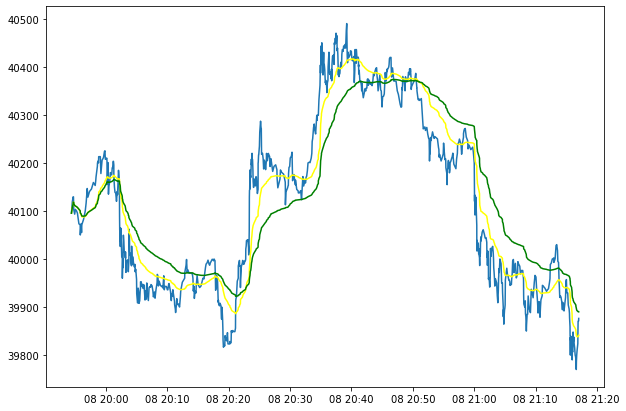

In [32]:
plot = close_df[:1000]
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(plot.price)
ax.plot(plot.fast, color="yellow")
ax.plot(plot.slow, color="green")

In [36]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

up = get_up_cross(close_df)
down = get_down_cross(close_df)

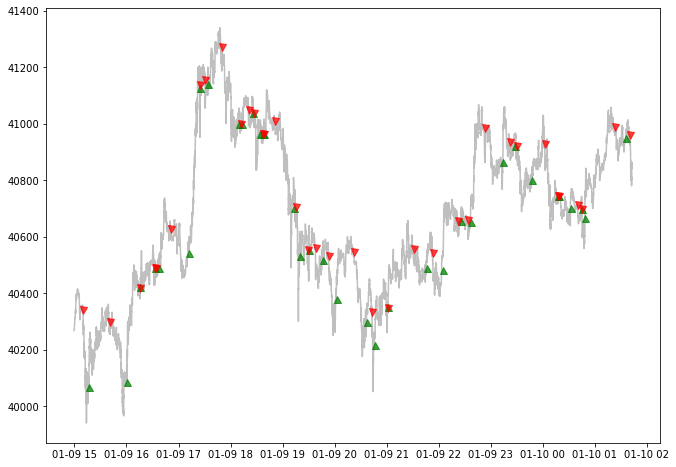

In [50]:
plot = close_df
plot["up"] = up
plot["down"] = down
plot = plot[20000:30000]

fig, ax = plt.subplots(figsize=(11,8))

# close_df.loc['2014':].plot(ax=ax, alpha=.5)
ax.plot(plot.price, alpha=.5, color="gray")

ax.plot(plot.up, marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
ax.plot(plot.down, marker='v', markersize=7,
                     alpha=0.75, label='upcross', color='r')




## Derive meta-labels for ptSl = [1,2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.

In [51]:
side_up = pd.Series(1, index=up.index)
side_down = pd.Series(-1, index=down.index)
side = pd.concat([side_up,side_down]).sort_index()
side

time
2021-01-08 19:54:54.289   -1
2021-01-08 19:57:03.317    1
2021-01-08 20:02:18.008   -1
2021-01-08 20:22:46.714    1
2021-01-08 20:51:01.037   -1
                          ..
2021-01-10 23:14:29.868   -1
2021-01-10 23:18:18.645    1
2021-01-10 23:22:27.403   -1
2021-01-10 23:22:51.483    1
2021-01-10 23:25:54.247   -1
Length: 489, dtype: int64

In [66]:
def get_events(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.reindex(tEvents)
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:side_,ptSl_=pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else: side_,ptSl_=side.reindex(trgt.index),ptSl[:2] #side.loc[trgt.index],ptSl[:2]
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
#     df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
#                     numThreads=numThreads,close=close,events=events,
#                     ptSl=ptSl_)
    df0 = apply_triple_barrier(close, events, ptSl_, events.index)
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

In [67]:
minRet = .0001 
ptsl=[0.1,0.2]

dailyVol = get_daily_vol(close_df['price'])
tEvents = get_t_events(close_df['price'],h=dailyVol.mean())
t1 = addVerticalBarrier(tEvents, close_df['price'], numDays=1)

ma_events = get_events(close_df['price'],tEvents,ptsl,target,minRet,1,
                      t1=t1,side=side)
ma_events

,t1,trgt,side
2021-01-09 19:56:34.575,2021-01-10 19:56:34.636,0.000510,NaN
2021-01-09 19:58:15.444,2021-01-10 19:58:16.218,0.001966,NaN
2021-01-09 19:58:30.182,2021-01-10 19:58:31.098,0.002218,NaN
2021-01-09 20:01:02.852,2021-01-10 20:01:03.829,0.001612,NaN
2021-01-09 20:03:06.049,2021-01-10 20:03:07.258,0.002897,NaN
...,...,...,...
2021-01-10 23:24:28.092,NaT,0.002268,NaN
2021-01-10 23:25:02.191,NaT,0.002139,NaN
2021-01-10 23:25:37.310,NaT,0.001870,NaN
2021-01-10 23:25:54.102,NaT,0.001681,NaN


In [68]:
ma_events.side.value_counts()

-1.0    13
 1.0    11
Name: side, dtype: int64

In [69]:
ma_side = ma_events.dropna().side
ma_side

2021-01-09 20:37:17.462    1.0
2021-01-09 21:01:09.429    1.0
2021-01-09 22:26:08.810    1.0
2021-01-10 02:07:16.653   -1.0
2021-01-10 02:19:05.256   -1.0
2021-01-10 03:22:13.879    1.0
2021-01-10 04:28:39.081   -1.0
2021-01-10 06:36:19.767   -1.0
2021-01-10 08:36:19.155   -1.0
2021-01-10 09:11:25.907    1.0
2021-01-10 09:23:54.064    1.0
2021-01-10 09:39:32.371   -1.0
2021-01-10 12:27:03.200   -1.0
2021-01-10 12:28:46.356    1.0
2021-01-10 13:04:58.861   -1.0
2021-01-10 14:03:37.352    1.0
2021-01-10 16:48:50.072    1.0
2021-01-10 18:20:17.106    1.0
2021-01-10 19:37:25.869   -1.0
2021-01-10 19:58:46.957   -1.0
2021-01-10 22:07:07.019   -1.0
2021-01-10 22:44:57.597    1.0
2021-01-10 22:48:44.523   -1.0
2021-01-10 22:57:19.293   -1.0
Name: side, dtype: float64

In [70]:
ma_bins = getBinsNew(ma_events,close_df['price'], t1).dropna()

In [71]:
ma_bins

,ret,bin
2021-01-09 20:37:17.462,-0.000698,0.0
2021-01-09 21:01:09.429,0.000682,1.0
2021-01-09 22:26:08.810,-0.001056,0.0
2021-01-10 02:07:16.653,-0.000500,0.0
2021-01-10 02:19:05.256,0.000384,1.0
2021-01-10 03:22:13.879,-0.000858,0.0
2021-01-10 04:28:39.081,-0.000380,0.0
2021-01-10 06:36:19.767,0.000294,1.0
2021-01-10 08:36:19.155,0.000390,1.0
2021-01-10 09:11:25.907,-0.000921,0.0


In [72]:
Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')
Xx

,ret,bin,side
2021-01-09 20:37:17.462,-0.000698,0.0,1
2021-01-09 21:01:09.429,0.000682,1.0,1
2021-01-09 22:26:08.810,-0.001056,0.0,1
2021-01-10 02:07:16.653,-0.000500,0.0,-1
2021-01-10 02:19:05.256,0.000384,1.0,-1
2021-01-10 03:22:13.879,-0.000858,0.0,1
2021-01-10 04:28:39.081,-0.000380,0.0,-1
2021-01-10 06:36:19.767,0.000294,1.0,-1
2021-01-10 08:36:19.155,0.000390,1.0,-1
2021-01-10 09:11:25.907,-0.000921,0.0,1


## Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underlying model (the crossing moving average) has decided the side, {−1,1}.

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

In [76]:
ma_side

2021-01-09 20:37:17.462    1.0
2021-01-09 21:01:09.429    1.0
2021-01-09 22:26:08.810    1.0
2021-01-10 02:07:16.653   -1.0
2021-01-10 02:19:05.256   -1.0
2021-01-10 03:22:13.879    1.0
2021-01-10 04:28:39.081   -1.0
2021-01-10 06:36:19.767   -1.0
2021-01-10 08:36:19.155   -1.0
2021-01-10 09:11:25.907    1.0
2021-01-10 09:23:54.064    1.0
2021-01-10 09:39:32.371   -1.0
2021-01-10 12:27:03.200   -1.0
2021-01-10 12:28:46.356    1.0
2021-01-10 13:04:58.861   -1.0
2021-01-10 14:03:37.352    1.0
2021-01-10 16:48:50.072    1.0
2021-01-10 18:20:17.106    1.0
2021-01-10 19:37:25.869   -1.0
2021-01-10 19:58:46.957   -1.0
2021-01-10 22:07:07.019   -1.0
2021-01-10 22:44:57.597    1.0
2021-01-10 22:48:44.523   -1.0
2021-01-10 22:57:19.293   -1.0
Name: side, dtype: float64

In [74]:
X = ma_side.values.reshape(-1,1)
X

array([[ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.]])

In [75]:
y = ma_bins.bin.values
y

array([0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 1., 0., 1.])

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=False)

In [79]:
n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy')
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=10000)

In [80]:
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.40      0.50      0.44         4
         1.0       0.71      0.62      0.67         8

    accuracy                           0.58        12
   macro avg       0.56      0.56      0.56        12
weighted avg       0.61      0.58      0.59        12



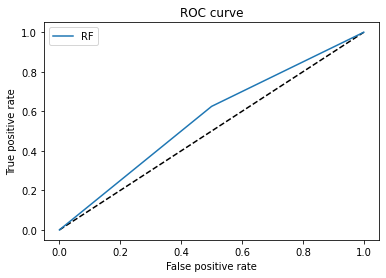

In [81]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Develop a mean-reverting strategy based on Bollinger bands. For each observation, the model suggests a side, but not a size of the bet.

In [82]:
def bbands(price, window=None, width=None, numsd=None):
    """ returns average, upper band, and lower band"""
    ave = price.rolling(window).mean()
    sd = price.rolling(window).std(ddof=0)
    if width:
        upband = ave * (1+width)
        dnband = ave * (1-width)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)        
    if numsd:
        upband = ave + (sd*numsd)
        dnband = ave - (sd*numsd)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [84]:
window=500
bb_df = pd.DataFrame()
bb_df['price'],bb_df['ave'],bb_df['upper'],bb_df['lower']=bbands(df.close, window=window, numsd=1)
bb_df.dropna(inplace=True)
bb_df

,price,ave,upper,lower
time,,,,
2021-01-08 20:36:39.962,40375.13,40086.154,40241.107,39931.202
2021-01-08 20:36:44.357,40395.04,40086.754,40242.319,39931.188
2021-01-08 20:36:46.652,40383.96,40087.284,40243.408,39931.159
2021-01-08 20:36:46.662,40371.00,40087.767,40244.394,39931.139
2021-01-08 20:36:49.200,40403.38,40088.315,40245.565,39931.065
...,...,...,...,...
2021-01-10 23:26:03.620,33291.65,33288.493,33455.089,33121.896
2021-01-10 23:26:05.362,33287.33,33289.622,33454.282,33124.961
2021-01-10 23:26:06.023,33238.66,33290.734,33453.153,33128.315


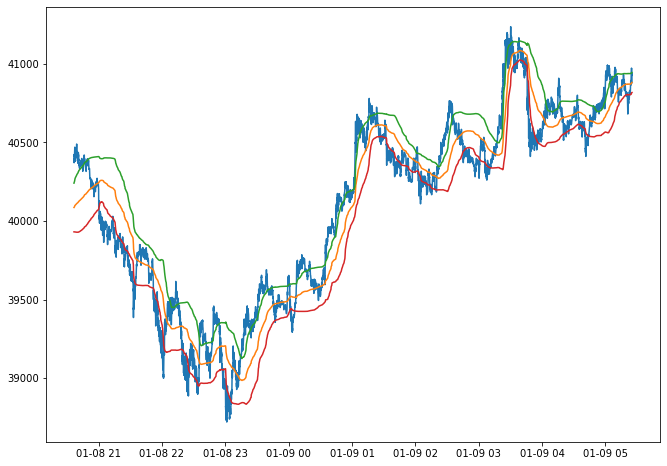

In [87]:
f,ax=plt.subplots(figsize=(11,8))
# bb_df.plot(ax=ax)
ax.plot(bb_df[:10000])

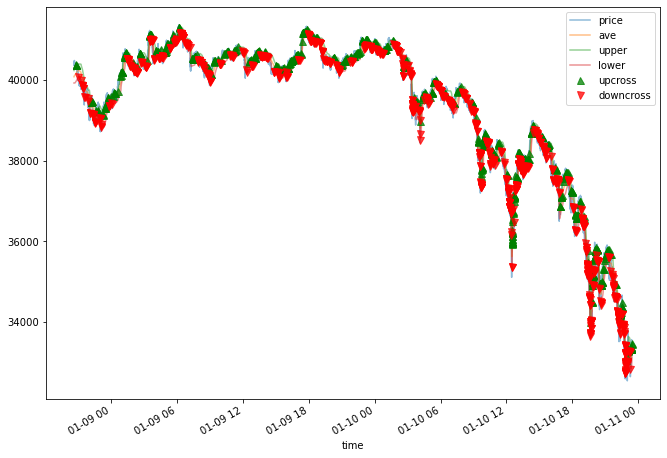

In [88]:
def get_up_cross(df, col):
    # col is price column
    crit1 = df[col].shift(1) < df.upper.shift(1)  
    crit2 = df[col] > df.upper
    return df[col][(crit1) & (crit2)]

def get_down_cross(df, col):
    # col is price column    
    crit1 = df[col].shift(1) > df.lower.shift(1) 
    crit2 = df[col] < df.lower
    return df[col][(crit1) & (crit2)]

bb_down = get_down_cross(bb_df, 'price')
bb_up = get_up_cross(bb_df, 'price') 

f, ax = plt.subplots(figsize=(11,8))

bb_df.loc['2014':].plot(ax=ax, alpha=.5)
bb_up.loc['2014':].plot(ax=ax, ls='', marker='^', markersize=7,
                        alpha=0.75, label='upcross', color='g')
bb_down.loc['2014':].plot(ax=ax, ls='', marker='v', markersize=7, 
                          alpha=0.75, label='downcross', color='r')
ax.legend()

## Derive meta-labels for ptSl = [0,2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.

In [89]:
bb_side_up = pd.Series(-1, index=bb_up.index) # sell on up cross for mean reversion
bb_side_down = pd.Series(1, index=bb_down.index) # buy on down cross for mean reversion
bb_side_raw = pd.concat([bb_side_up,bb_side_down]).sort_index()
bb_side_raw

time
2021-01-08 20:45:26.381   -1
2021-01-08 20:48:21.749   -1
2021-01-08 20:49:17.612   -1
2021-01-08 20:49:27.796   -1
2021-01-08 21:00:24.806    1
                          ..
2021-01-10 23:22:58.773   -1
2021-01-10 23:23:02.390   -1
2021-01-10 23:23:04.410   -1
2021-01-10 23:24:24.929   -1
2021-01-10 23:25:16.028   -1
Length: 1699, dtype: int64

In [94]:
minRet = .001 
ptsl=[0,2]
bb_events = get_events(df.close,tEvents,ptsl,target,minRet,1,t1=t1,side=bb_side_raw)
bb_events

<ipython-input-16-647c20009319>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pt=pd.Series(index=events.index) #NaNs


,t1,trgt,side
2021-01-09 19:58:15.444,2021-01-10 19:58:16.218,0.001966,NaN
2021-01-09 19:58:30.182,2021-01-10 19:58:31.098,0.002218,NaN
2021-01-09 20:01:02.852,2021-01-10 20:01:03.829,0.001612,NaN
2021-01-09 20:03:06.049,2021-01-10 20:03:07.258,0.002897,NaN
2021-01-09 20:13:05.710,2021-01-09 22:40:10.692,0.002323,-1.0
...,...,...,...
2021-01-10 23:24:28.092,NaT,0.002268,NaN
2021-01-10 23:25:02.191,NaT,0.002139,NaN
2021-01-10 23:25:37.310,NaT,0.001870,NaN
2021-01-10 23:25:54.102,NaT,0.001681,NaN


In [95]:
bb_side = bb_events.dropna().side
bb_side

2021-01-09 20:13:05.710   -1.0
2021-01-09 22:36:39.046   -1.0
2021-01-10 03:23:26.840    1.0
2021-01-10 03:23:54.947    1.0
2021-01-10 03:30:02.700    1.0
                          ... 
2021-01-10 23:01:52.125   -1.0
2021-01-10 23:02:14.722   -1.0
2021-01-10 23:03:10.062   -1.0
2021-01-10 23:11:24.437    1.0
2021-01-10 23:21:12.914   -1.0
Name: side, Length: 121, dtype: float64

In [97]:
bb_side.value_counts()

 1.0    74
-1.0    47
Name: side, dtype: int64

In [99]:
bb_bins = get_bins(bb_events,df.close).dropna()
bb_bins

,ret,bin
2021-01-09 19:58:15.444,-0.115894,-1.0
2021-01-09 19:58:30.182,-0.117964,-1.0
2021-01-09 20:01:02.852,-0.118771,-1.0
2021-01-09 20:03:06.049,-0.116200,-1.0
2021-01-09 20:13:05.710,0.004714,1.0
...,...,...
2021-01-10 23:01:52.125,0.013896,1.0
2021-01-10 23:02:14.722,0.013269,1.0
2021-01-10 23:03:10.062,0.006698,1.0
2021-01-10 23:11:24.437,-0.006144,-1.0


In [100]:
bb_bins.bin.value_counts()

-1.0    131
 1.0     47
Name: bin, dtype: int64

## Train a random forest to decide whether to trade or not. Use as features: volatility, serial correlation, and the crossing moving averages from exercise 2.

In [101]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

def df_rolling_autocorr(df, window, lag=1):
    """Compute rolling column-wise autocorrelation for a DataFrame."""

    return (df.rolling(window=window)
            .corr(df.shift(lag))) # could .dropna() here

#df_rolling_autocorr(d1, window=21).dropna().head()

In [102]:
srl_corr = df_rolling_autocorr(returns(df.close), window=window).rename('srl_corr')
srl_corr

time
2021-01-08 19:54:31.003         NaN
2021-01-08 19:54:39.317         NaN
2021-01-08 19:54:42.244         NaN
2021-01-08 19:54:44.811         NaN
2021-01-08 19:54:54.289         NaN
                             ...   
2021-01-10 23:26:03.620   -0.048236
2021-01-10 23:26:05.362   -0.045910
2021-01-10 23:26:06.023   -0.048688
2021-01-10 23:26:06.506   -0.050569
2021-01-10 23:26:07.521   -0.061814
Name: srl_corr, Length: 79372, dtype: float64

In [103]:
features = (pd.DataFrame()
            .assign(vol=bb_events.trgt)
            .assign(ma_side=ma_side)
            .assign(srl_corr=srl_corr)
            .drop_duplicates()
            .dropna())
features

,vol,ma_side,srl_corr
2021-01-09 20:37:17.462,0.002540,1.0,0.079115
2021-01-09 21:01:09.429,0.002426,1.0,0.060873
2021-01-09 22:26:08.810,0.004710,1.0,-0.043220
2021-01-10 02:07:16.653,0.002243,-1.0,0.007297
2021-01-10 02:19:05.256,0.001308,-1.0,-0.012137
2021-01-10 03:22:13.879,0.002110,1.0,-0.226887
2021-01-10 04:28:39.081,0.001010,-1.0,-0.002470
2021-01-10 06:36:19.767,0.002519,-1.0,0.095138
2021-01-10 08:36:19.155,0.001508,-1.0,0.113267
2021-01-10 09:11:25.907,0.001192,1.0,0.019759


In [104]:
Xy = (pd.merge_asof(features, bb_bins[['bin']], 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
Xy

,vol,ma_side,srl_corr,bin
2021-01-09 20:37:17.462,0.002540,1.0,0.079115,-1.0
2021-01-09 21:01:09.429,0.002426,1.0,0.060873,-1.0
2021-01-09 22:26:08.810,0.004710,1.0,-0.043220,-1.0
2021-01-10 02:07:16.653,0.002243,-1.0,0.007297,-1.0
2021-01-10 02:19:05.256,0.001308,-1.0,-0.012137,-1.0
2021-01-10 03:22:13.879,0.002110,1.0,-0.226887,-1.0
2021-01-10 04:28:39.081,0.001010,-1.0,-0.002470,1.0
2021-01-10 06:36:19.767,0.002519,-1.0,0.095138,-1.0
2021-01-10 08:36:19.155,0.001508,-1.0,0.113267,-1.0
2021-01-10 09:11:25.907,0.001192,1.0,0.019759,-1.0


In [105]:
Xy.bin.value_counts()

-1.0    17
 1.0     7
Name: bin, dtype: int64

/Volumes/Storage/Programming/bitcoin-printer/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Volumes/Storage/Programming/bitcoin-printer/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Volumes/Storage/Programming/bitcoin-printer/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

              precision    recall  f1-score   support

    no_trade       0.58      1.00      0.74         7
       trade       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12



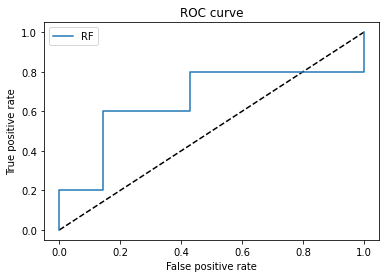

In [108]:

X = Xy.drop('bin',axis=1).values
y = Xy['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy')
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names=['no_trade','trade']))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Miscellaneous

In [117]:
def get_t_events(g_raw, h):
    """
    Implementation of the symmetric CUSUM filter seen in chapter 2.5.2
    
    Arguments:
    g_raw -- the raw time series to filter (possibly pandas series)
    h -- threshold (possibly float or int)
    
    Purpose:
    The CUSUM filter is a quality-control method, designed to detect a shift in the mean value of a measured quantity away from a target value. 
    """
    t_events, s_pos, s_neg = [], 0, 0
    diff = g_raw.diff()
    for i in diff.index[1:]:
        s_pos, s_neg = max(0, s_pos+diff.loc[i]), min(0, s_neg+diff.loc[i])
        if s_neg<-h[i]:
            s_neg = 0
            t_events.append(i)
        elif s_pos>h[i]:
            s_pos = 0
            t_events.append(i)
        else:
            t_events.append(None)
    return t_events

In [126]:
a = get_t_events(df.close, 500)
a = [None] + a

In [127]:
b = list(map(lambda x, c: c if x != None else None, a, df.close))

In [128]:
len(a)

79373

In [129]:
len(df.close)

79373

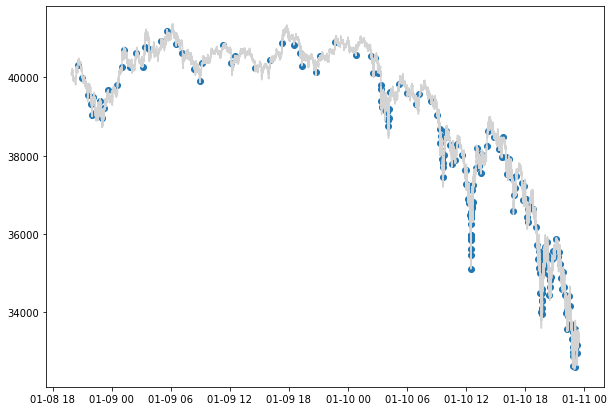

In [130]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(df.close.index, b)

ax.plot(df.close, color="lightgrey")
